In [44]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.model_selection import train_test_split


In [45]:
# Load the data
df_train = pd.read_csv('6722-credit-card-default-data.csv')
df_test = pd.read_csv('6722-pilot-customers.csv')


In [46]:
# Set the 'ID' column as the index
df_train.set_index('ID', inplace=True)
df_test.set_index('ID', inplace=True)


In [47]:
# Check for missing values
print(df_train.isnull().sum())
print(df_test.isnull().sum())


LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_1        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
DEFAULT      0
dtype: int64
LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_1        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
dtype: int64


In [48]:
# Handle missing values
df_train.fillna(df_train.median(), inplace=True)
df_test.fillna(df_test.median(), inplace=True)


In [49]:
# Verify that there are no missing values left
print(df_train.isnull().sum())
print(df_test.isnull().sum())

LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_1        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
DEFAULT      0
dtype: int64
LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_1        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
dtype: int64


In [50]:
# Display the shape of the datasets
print("Training Data Shape:", df_train.shape)
print("Test Data Shape:", df_test.shape)

Training Data Shape: (24000, 24)
Test Data Shape: (1000, 23)


In [51]:
# Create target variable
df_train["Give_Loan"] = np.where(df_train['DEFAULT'] == 1, 0, 1)

# Feature engineering: summing up payment and bill amounts
df_train['PAY_SUM'] = df_train[['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']].sum(axis=1)
df_test['PAY_SUM'] = df_test[['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']].sum(axis=1)

df_train['BILL_SUM'] = df_train[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].sum(axis=1)
df_test['BILL_SUM'] = df_test[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']].sum(axis=1)

df_train['PAY_AMT_SUM'] = df_train[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].sum(axis=1)
df_test['PAY_AMT_SUM'] = df_test[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']].sum(axis=1)


In [52]:
print(df_train.head())
print(df_test.head())


    LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_1  PAY_2  PAY_3  PAY_4  \
ID                                                                         
1     20000.0    2          2         1   24      2      2     -1     -1   
2     90000.0    2          2         2   34      0      0      0      0   
3     50000.0    2          2         1   37      0      0      0      0   
4     50000.0    1          2         1   57     -1      0     -1      0   
5     50000.0    1          1         2   37      0      0      0      0   

    PAY_5  ...  PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  DEFAULT  \
ID         ...                                                              
1      -2  ...     689.0       0.0       0.0       0.0       0.0        1   
2       0  ...    1500.0    1000.0    1000.0    1000.0    5000.0        0   
3       0  ...    2019.0    1200.0    1100.0    1069.0    1000.0        0   
4       0  ...   36681.0   10000.0    9000.0     689.0     679.0        0   
5    

In [53]:
from sklearn.model_selection import train_test_split

# Features and target variable
X = df_train.drop(['DEFAULT', 'Give_Loan'], axis=1)
y = df_train['Give_Loan']

# Split the data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=123)

print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)


(19200, 26) (4800, 26) (19200,) (4800,)


In [54]:
# Initialize models
gbc = GradientBoostingClassifier(random_state=123)
catboost = CatBoostClassifier(random_state=123, verbose=0)
rf = RandomForestClassifier(random_state=123)
xgb = XGBClassifier(random_state=123, use_label_encoder=False, eval_metric='logloss')


In [55]:
# Train models
gbc.fit(X_train, y_train)
catboost.fit(X_train, y_train)
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=123, ...)

In [56]:

# Predict on validation set
y_pred_gbc = gbc.predict(X_valid)
y_pred_catboost = catboost.predict(X_valid)
y_pred_rf = rf.predict(X_valid)
y_pred_xgb = xgb.predict(X_valid)



In [57]:
# Evaluate models
def evaluate_model(y_valid, y_pred, model_name):
    accuracy = accuracy_score(y_valid, y_pred)
    auc = roc_auc_score(y_valid, y_pred)
    print(f"{model_name} - Accuracy: {accuracy}, AUC: {auc}")
    print(confusion_matrix(y_valid, y_pred))
    print(classification_report(y_valid, y_pred))

evaluate_model(y_valid, y_pred_gbc, "Gradient Boosting")
evaluate_model(y_valid, y_pred_catboost, "CatBoost")
evaluate_model(y_valid, y_pred_rf, "Random Forest")
evaluate_model(y_valid, y_pred_xgb, "XGBoost")

Gradient Boosting - Accuracy: 0.8277083333333334, AUC: 0.6668672542339407
[[ 397  635]
 [ 192 3576]]
              precision    recall  f1-score   support

           0       0.67      0.38      0.49      1032
           1       0.85      0.95      0.90      3768

    accuracy                           0.83      4800
   macro avg       0.76      0.67      0.69      4800
weighted avg       0.81      0.83      0.81      4800

CatBoost - Accuracy: 0.82125, AUC: 0.6602910679899274
[[ 390  642]
 [ 216 3552]]
              precision    recall  f1-score   support

           0       0.64      0.38      0.48      1032
           1       0.85      0.94      0.89      3768

    accuracy                           0.82      4800
   macro avg       0.75      0.66      0.68      4800
weighted avg       0.80      0.82      0.80      4800

Random Forest - Accuracy: 0.81875, AUC: 0.6632721078358762
[[ 403  629]
 [ 241 3527]]
              precision    recall  f1-score   support

           0       0.63

In [59]:
# Predict on the test set
y_test_pred_gbc = gbc.predict(X_test)

In [60]:
# Calculate profit
def calculate_profit(y_pred):
    tp = np.sum(np.where(y_pred == 1, 1500, 0))
    fp = np.sum(np.where(y_pred == 0, -5000, 0))
    profit = tp + fp
    return profit

In [61]:
# Calculate profit for Gradient Boosting predictions
profit_gbc = calculate_profit(y_test_pred_gbc)
print(f"Calculated Profit: {profit_gbc}")

Calculated Profit: 681000


In [62]:
# Create final recommendation
df_test['Give_Loan'] = y_test_pred_gbc
recommendation = df_test[['Give_Loan']]
recommendation.to_csv('TeamA_Recommendations.csv', index=False)

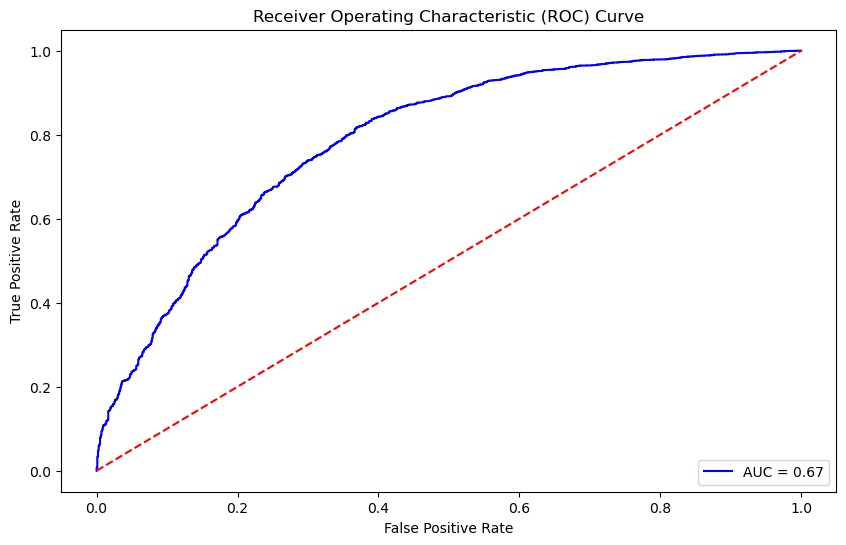

In [63]:
from sklearn.metrics import roc_curve, roc_auc_score

# Plot ROC curve for Gradient Boosting
fpr, tpr, _ = roc_curve(y_valid, gbc.predict_proba(X_valid)[:, 1])
roc_auc = roc_auc_score(y_valid, y_pred_gbc)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


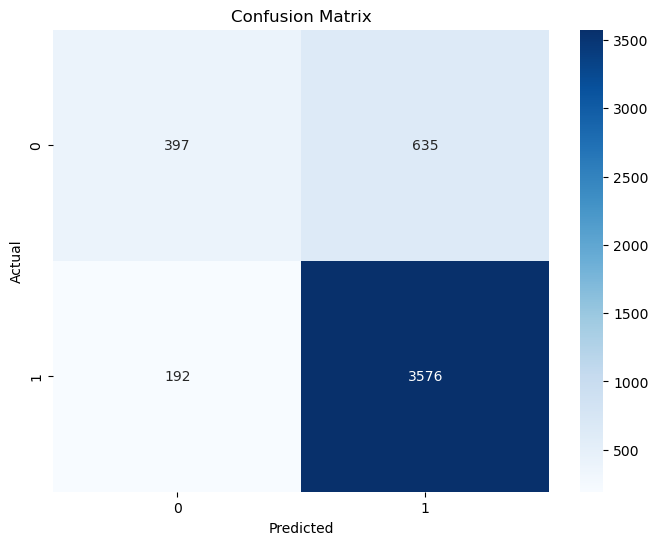

In [64]:
# Plot confusion matrix for Gradient Boosting
conf_matrix = confusion_matrix(y_valid, y_pred_gbc)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


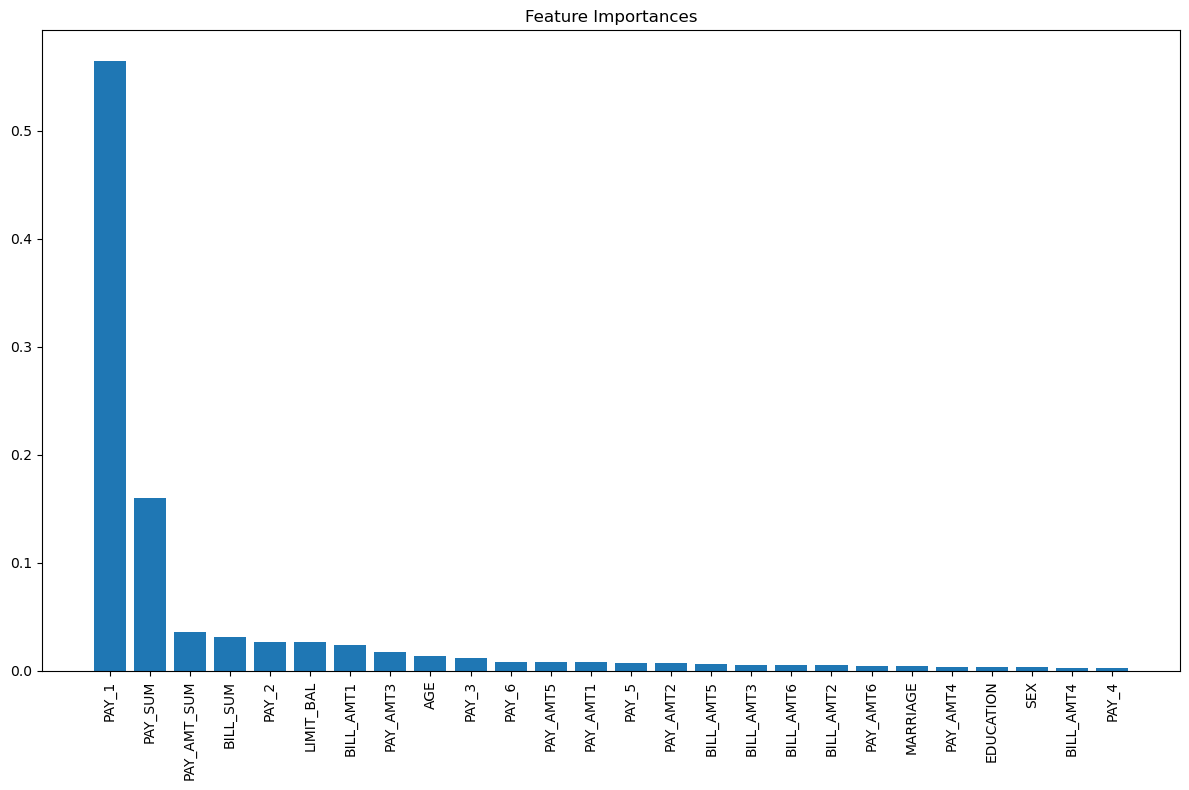

In [65]:
# Plot feature importance for Gradient Boosting
importances = gbc.feature_importances_
indices = np.argsort(importances)[::-1]
features = X_train.columns

plt.figure(figsize=(12, 8))
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), features[indices], rotation=90)
plt.tight_layout()
plt.show()


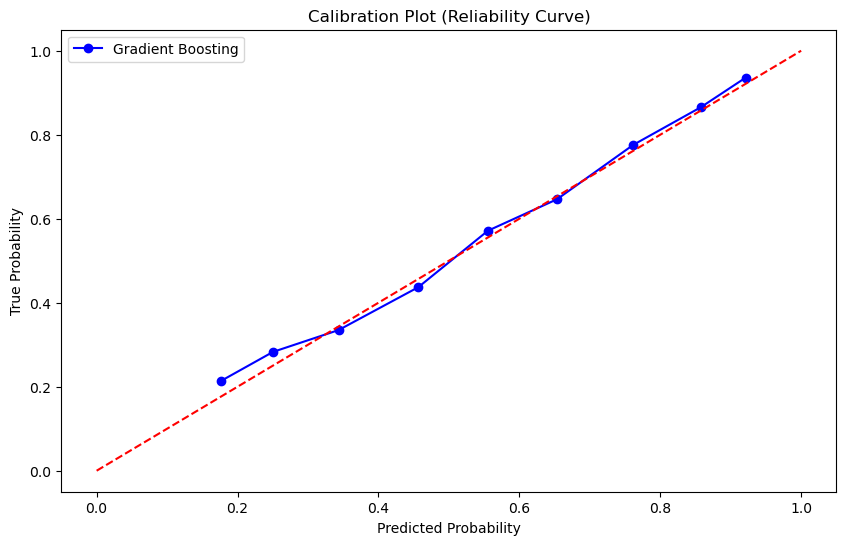

In [66]:
from sklearn.calibration import calibration_curve

# Plot calibration curve for Gradient Boosting
prob_true, prob_pred = calibration_curve(y_valid, gbc.predict_proba(X_valid)[:, 1], n_bins=10)

plt.figure(figsize=(10, 6))
plt.plot(prob_pred, prob_true, marker='o', color='blue', label='Gradient Boosting')
plt.plot([0, 1], [0, 1], linestyle='--', color='red')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Plot (Reliability Curve)')
plt.legend()
plt.show()
